# ****Check GPU****

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is being used!")
    except RuntimeError as e:
        print(e)

2025-04-23 04:20:17.154446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745382017.353157      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745382017.411320      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is being used!


# **Import Dataset**

In [2]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image

In [3]:
import kagglehub
import os

# Download the dataset from KaggleHub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# Match GitHub structure by creating a new parent dir name
dataset_directory_location = os.path.join(path)
os.listdir(dataset_directory_location)

# GitHub-style train/test folder names (manually renamed or aliased from 'Training' and 'Testing')
train_dataset_location = os.path.join(dataset_directory_location, 'Training')  # or 'train' if renamed
test_dataset_location = os.path.join(dataset_directory_location, 'Testing')    # or 'test' if renamed

# Check the contents to confirm
if os.path.exists(train_dataset_location) and os.path.exists(test_dataset_location):
    print("✅ Train and Test Paths Exist")
    print("🧠 Train Classes:", os.listdir(train_dataset_location))
    print("🧠 Test Classes:", os.listdir(test_dataset_location))
else:
    raise FileNotFoundError("❌ Error: Train or Test path does not exist.")

✅ Train and Test Paths Exist
🧠 Train Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
🧠 Test Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [4]:
print("Base path:", path)
print("Contents:", os.listdir(path))

Base path: /kaggle/input/brain-tumor-mri-dataset
Contents: ['Training', 'Testing']


# **Dataset Loading and Preprocessing**

In [5]:
correct_image_shape = (224, 224, 3)

train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    train_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

test_image_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Sample Visualisation**

(512, 512, 3)

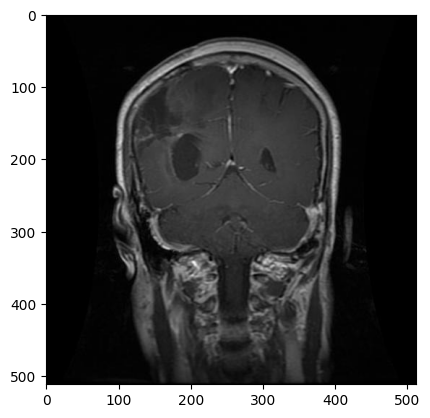

In [6]:
brain_img_glicoma = os.path.join(train_dataset_location, 'glioma')
os.listdir(brain_img_glicoma)[:1]
brain_img_glicoma_read = imread(os.path.join(brain_img_glicoma, 'Tr-gl_0010.jpg'))
plt.imshow(brain_img_glicoma_read)
brain_img_glicoma_read.shape 

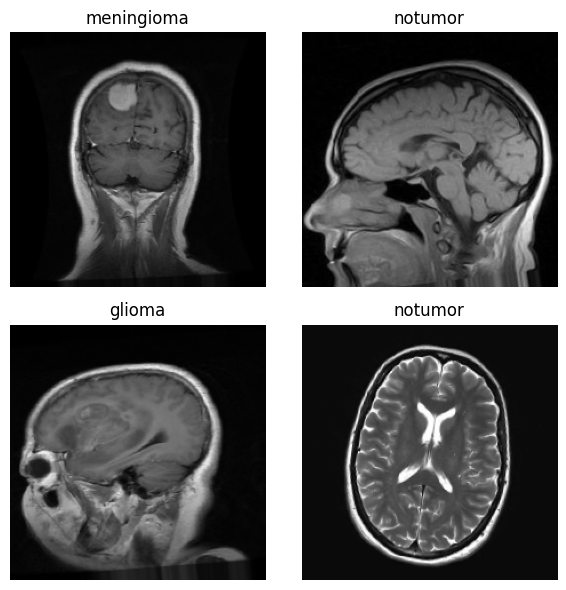

In [7]:
import matplotlib.pyplot as plt

# Helper function to show images from the generator
def show_images(generator, class_names, num_images=4):
    images, labels = next(generator)  # fetch one batch
    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i].argmax()])  # decode one-hot
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Extract class names from the generator itself
class_names = list(train_image_gen.class_indices.keys())

# Call the function with your training generator
show_images(train_image_gen, class_names)

# **Build and Train Model**

In [19]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average, Dense, Dropout, BatchNormalization
import tensorflow as tf

# Load models
vgg_loaded = load_model("/kaggle/input/vgg19_model/keras/default/1/vgg19_model.keras", compile=False)
inception_loaded = load_model("/kaggle/input/inceptionv3_model/keras/default/1/inceptionv3_model.keras", compile=False)
custom_loaded = load_model("/kaggle/input/custom_cnn_model/keras/default/1/custom_cnn_model.keras", compile=False)

# Define input shape
input_shape = (224, 224, 3)
dummy_input = tf.keras.Input(shape=input_shape)

# Call models once to set input/output tensors
vgg_output = vgg_loaded(dummy_input)
inception_output = inception_loaded(dummy_input)
custom_output = custom_loaded(dummy_input)

# Wrap models into uniquely named Models
vgg_model = Model(inputs=dummy_input, outputs=vgg_output, name="vgg_model")
inception_model = Model(inputs=dummy_input, outputs=inception_output, name="inception_model")
custom_model = Model(inputs=dummy_input, outputs=custom_output, name="custom_model")

# New input for the ensemble
ensemble_input = Input(shape=input_shape)

# Call wrapped models with ensemble input
vgg_out = vgg_model(ensemble_input)
inception_out = inception_model(ensemble_input)
custom_out = custom_model(ensemble_input)

# Average outputs
avg_output = Average()([vgg_out, inception_out, custom_out])

# Classifier head
x = BatchNormalization()(avg_output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
final_output = Dense(4, activation='softmax')(x)

# Final model
ensemble_model = Model(inputs=ensemble_input, outputs=final_output, name="ensemble_model")
ensemble_model.summary()

Model: "ensemble_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg_model (Functional)    │ (None, 4)              │     23,341,028 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_model           │ (None, 4)              │     28,566,212 │ input_layer_6[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_model (Functional) │ (None, 4)              │      5,745,028 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_5 (Average)       │ (None, 4)              │              0 │ vgg_model[0][0],       │
│                           │                        │                │ inception_model[0][0], │
│                           │                        │                │ custom_model[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 4)              │             16 │ average_5[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 128)            │            640 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 128)            │            512 │ dense_15[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 32)             │          4,128 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 32)             │            128 │ dense_16[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 4)              │            132 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 57,657,824 (219.95 MB)

 Trainable params: 15,590,008 (59.47 MB)

 Non-trainable params: 42,067,816 (160.48 MB)

In [20]:
for model in [vgg_model, inception_model, custom_cnn_model]:
    print(f"Model name: {model.name}")
    for layer in model.layers:
        print(layer.name)

Model name: vgg_model
input_layer_5
sequential
Model name: inception_model
input_layer_5
sequential
Model name: sequential_2
conv2d_6
batch_normalization_12
max_pooling2d_6
conv2d_7
batch_normalization_13
max_pooling2d_7
conv2d_8
batch_normalization_14
max_pooling2d_8
flatten_2
batch_normalization_15
dense_6
batch_normalization_16
dropout_4
dense_7
batch_normalization_17
dropout_5
dense_8


In [21]:
from IPython.display import FileLink, display
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import json

# Constants for saving
MODEL_PATH = "/kaggle/working/ensemble_model.keras"
HISTORY_PATH = "/kaggle/working/ensemble_history.json"

# Early stopping and checkpoint callbacks
early_stop_loss = EarlyStopping(monitor='loss', patience=2, verbose=1)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

checkpoint_cb = ModelCheckpoint(
    MODEL_PATH,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Compile the ensemble model
ensemble_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Train the ensemble model
history = ensemble_model.fit(
    train_image_gen,
    validation_data=test_image_gen,
    epochs=30,
    callbacks=[early_stop_loss, early_stop_val_loss, checkpoint_cb]
)

# Save training history
with open(HISTORY_PATH, "w") as f:
    json.dump(history.history, f)

# Display download links
print("✅ Ensemble model and training history saved!")
display(FileLink(MODEL_PATH, result_html_prefix="📥 Download Ensemble model: "))
display(FileLink(HISTORY_PATH, result_html_prefix="📊 Download training history: "))


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745383012.910342     112 service.cc:148] XLA service 0x7b603c002610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745383012.911277     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745383012.911298     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745383016.408361     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745383042.824840     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4357 - loss: 1.3775
Epoch 1: val_accuracy improved from -inf to 0.63463, saving model to /kaggle/working/ensemble_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 190s 374ms/step - accuracy: 0.4358 - loss: 1.3771 - val_accuracy: 0.6346 - val_loss: 0.8518
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6125 - loss: 0.9613
Epoch 2: val_accuracy improved from 0.63463 to 0.94966, saving model to /kaggle/working/ensemble_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 90s 247ms/step - accuracy: 0.6126 - loss: 0.9612 - val_accuracy: 0.9497 - val_loss: 0.3864
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7108 - loss: 0.7500
Epoch 3: val_accuracy improved from 0.94966 to 0.96873, saving model to /kaggle/working/ensemble_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 260ms/step - accuracy: 0.7109 - loss: 0.7499 - val_accuracy: 0.9687 - val_loss: 0.2618
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accura

/kaggle/working/ensemble_model.keras

/kaggle/working/ensemble_history.json

# **Graphical Loss vs Accuracy plot**

In [22]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv("/kaggle/working/training_history.csv", index=False)

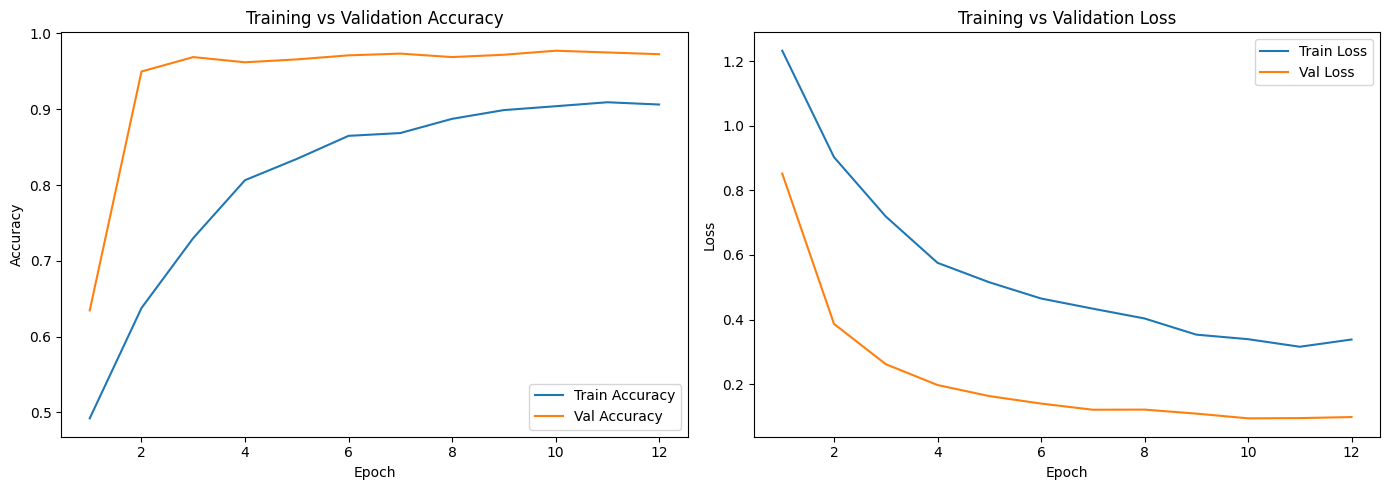

In [23]:
import matplotlib.pyplot as plt

# Load history from the DataFrame (already created)
acc = history_df["accuracy"]
val_acc = history_df["val_accuracy"]
loss = history_df["loss"]
val_loss = history_df["val_loss"]

epochs = range(1, len(acc) + 1)

# Create a figure with two subplots
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# **Model Evaluation**

In [25]:
# Compile model before evaluation (required for .evaluate and .predict)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Evaluate on training data
train_acc = model.evaluate(train_image_gen, steps=len(train_image_gen))[1]

# Evaluate on test data
test_acc = model.evaluate(test_image_gen, steps=len(test_image_gen))[1]

print(f"✅ Final Train Accuracy: {train_acc:.4f}")
print(f"✅ Final Test Accuracy: {test_acc:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 67s 186ms/step - accuracy: 0.9022 - loss: 0.2785
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8964 - loss: 0.2729
✅ Final Train Accuracy: 0.8983
✅ Final Test Accuracy: 0.8940


# **Sample Prediction**

In [27]:
# Choose an image path to test
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0026.jpg"

# Load and preprocess the image
sample_img_load = image.load_img(img_path, target_size=correct_image_shape)
sample_img_to_arr = image.img_to_array(sample_img_load)
sample_img_to_arr = sample_img_to_arr / 255.0  # Normalize
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, axis=0)

# Predict
prediction = model.predict(sample_img_to_arr_expand_dim)[0]
pred_result = np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


In [28]:
# Define class names in order of training
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
pred_final_result = class_names[pred_result]

# Output
print(f"🧠 Predicted Tumor Type: {pred_final_result}")

🧠 Predicted Tumor Type: no tumor
